<a href="https://colab.research.google.com/github/CeaPanochka/NNandMnADIP/blob/main/%D0%A6%D1%8B%D0%B1%D1%83%D0%BB%D0%B0%D0%B5%D0%B2_NN_2_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'E:\Anaconda Work\data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
os.listdir(data_dir)

['bird', 'cat', 'dog']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3300 files belonging to 3 classes.
Using 2640 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3300 files belonging to 3 classes.
Using 660 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['bird', 'cat', 'dog']


## Визуализация данных

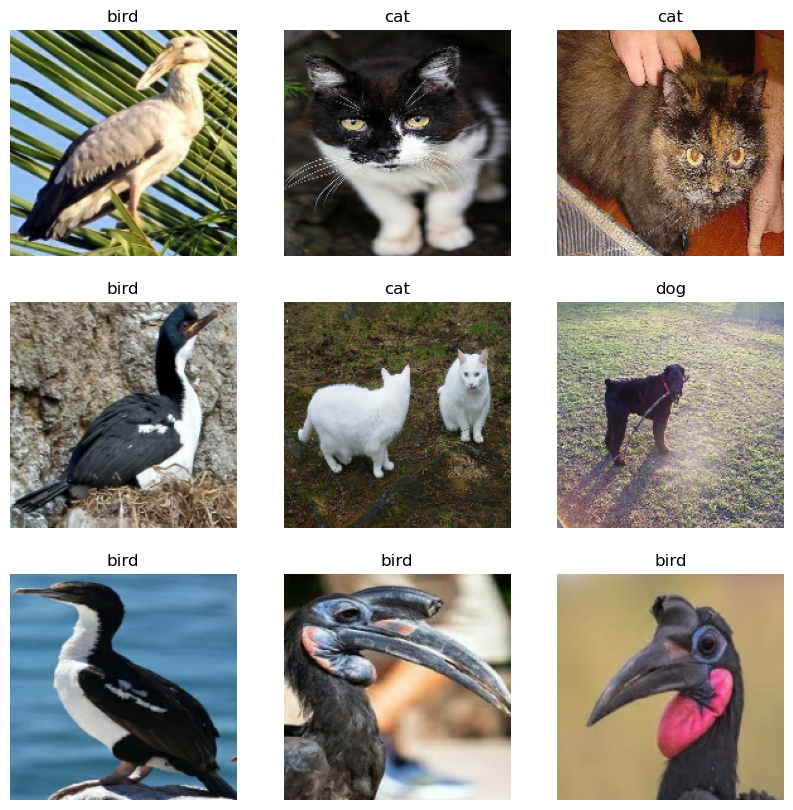

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Настройка данных

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Стандартизация данных

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9963137


# Создание модели

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

# Обучение модели

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
99/99 [==============================] - 42s 418ms/step - loss: 0.9917 - accuracy: 0.5052 - val_loss: 0.9025 - val_accuracy: 0.5939
Epoch 2/10
99/99 [==============================] - 41s 416ms/step - loss: 0.7649 - accuracy: 0.6542 - val_loss: 0.6760 - val_accuracy: 0.6942
Epoch 3/10
99/99 [==============================] - 42s 420ms/step - loss: 0.6582 - accuracy: 0.7106 - val_loss: 0.6863 - val_accuracy: 0.6916
Epoch 4/10
99/99 [==============================] - 42s 424ms/step - loss: 0.4919 - accuracy: 0.7883 - val_loss: 0.7739 - val_accuracy: 0.6637
Epoch 5/10
99/99 [==============================] - 41s 416ms/step - loss: 0.3774 - accuracy: 0.8434 - val_loss: 0.7302 - val_accuracy: 0.7094
Epoch 6/10
99/99 [==============================] - 41s 414ms/step - loss: 0.2416 - accuracy: 0.9122 - val_loss: 0.8082 - val_accuracy: 0.7259
Epoch 7/10
99/99 [==============================] - 41s 413ms/step - loss: 0.1513 - accuracy: 0.9493 - val_loss: 0.8359 - val_accuracy: 0.7525

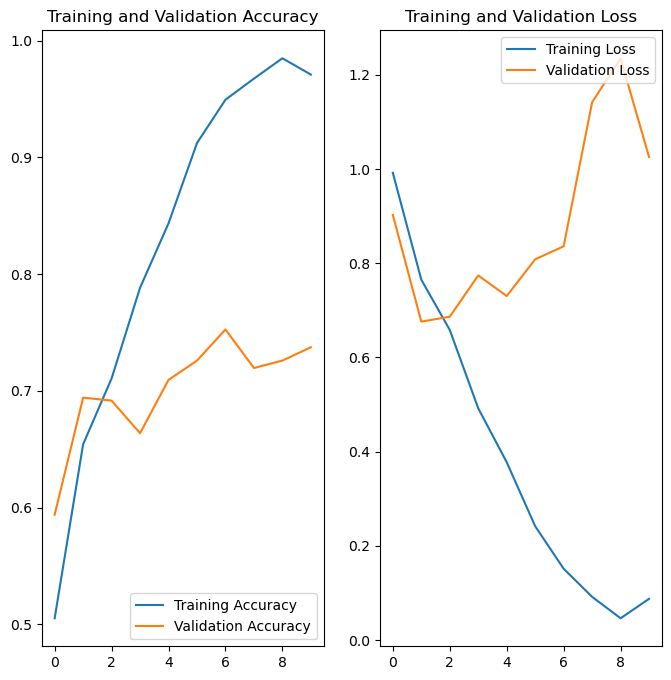

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Исправляем переобучение

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

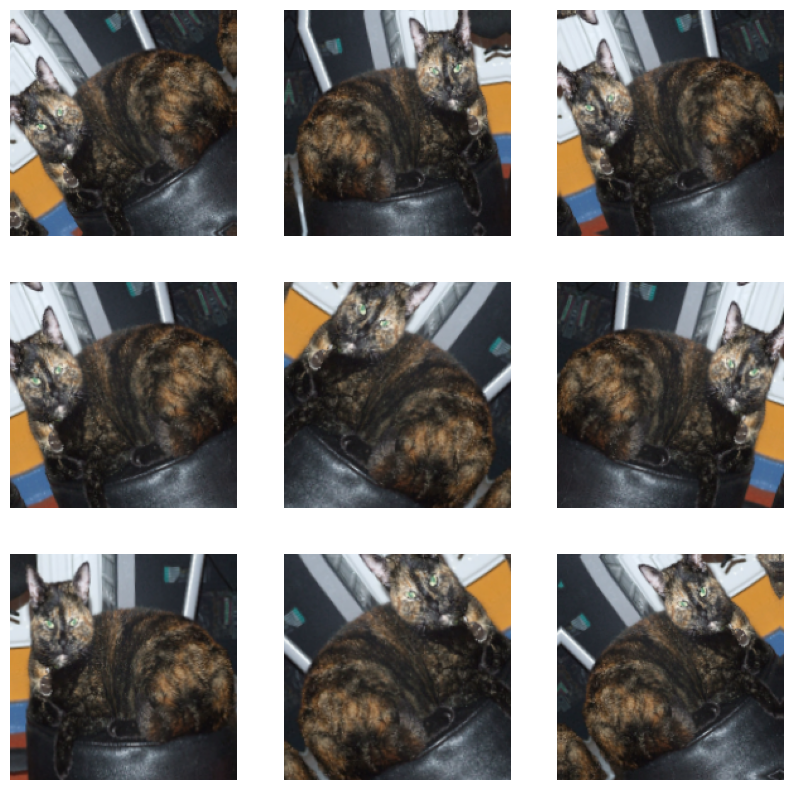

In [ ]:
# Проверяем, как выглядят доп изображения
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Создадим новую модель

In [ ]:
# помимо увеличения данных добавим отсев
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss=['sparse_categorical_crossentropy'],
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='E:\Anaconda Work\logs')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

Epoch 1/15
83/83 [==============================] - 40s 464ms/step - loss: 1.1279 - accuracy: 0.4356 - val_loss: 0.9665 - val_accuracy: 0.5258
Epoch 2/15
83/83 [==============================] - 37s 445ms/step - loss: 1.0129 - accuracy: 0.4799 - val_loss: 0.9416 - val_accuracy: 0.5470
Epoch 3/15
83/83 [==============================] - 37s 443ms/step - loss: 0.9296 - accuracy: 0.5572 - val_loss: 0.8538 - val_accuracy: 0.6121
Epoch 4/15
83/83 [==============================] - 36s 433ms/step - loss: 0.8776 - accuracy: 0.5803 - val_loss: 0.8015 - val_accuracy: 0.6455
Epoch 5/15
83/83 [==============================] - 36s 432ms/step - loss: 0.8359 - accuracy: 0.6212 - val_loss: 0.8328 - val_accuracy: 0.6091
Epoch 6/15
83/83 [==============================] - 36s 437ms/step - loss: 0.7647 - accuracy: 0.6689 - val_loss: 0.7912 - val_accuracy: 0.6212
Epoch 7/15
83/83 [==============================] - 37s 448ms/step - loss: 0.7193 - accuracy: 0.6833 - val_loss: 0.7572 - val_accuracy: 0.6985

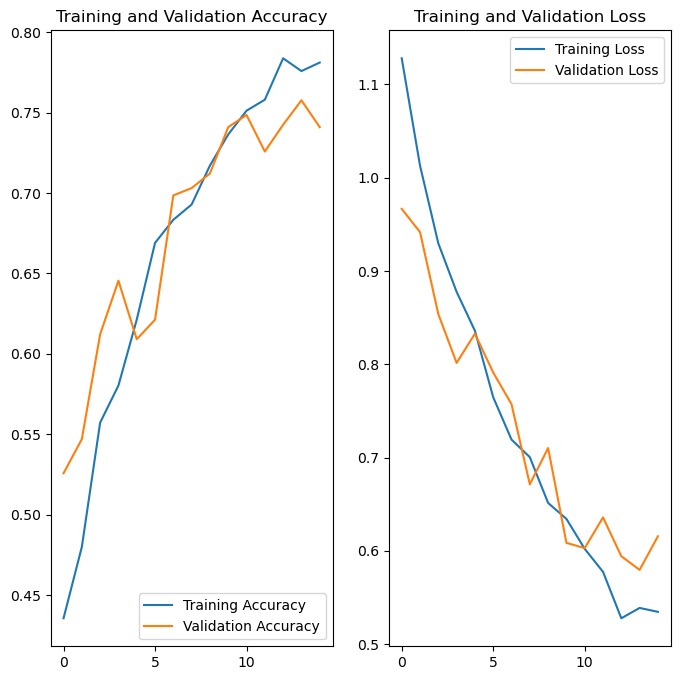

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Предсказание новых данных

In [ ]:
def prediction(test_file):
    path = f'E:\Anaconda Work\\test\\{test_file}'
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [ ]:
prediction('cat\\cat_3.jpg')
prediction('bird\\bird_1.jpg')
prediction('bird\\bird_4.jpg') # птица
prediction('dog\\dog_1.jpg')
prediction('dog\\dog_2.jpg')

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to cat with a 80.53 percent confidence.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to cat with a 50.07 percent confidence.
1/1 [==============================] - 0s 22ms/step
This image most likely belongs to dog with a 38.84 percent confidence.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to dog with a 70.43 percent confidence.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to dog with a 62.45 percent confidence.


# Сохраняем модель

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
os.path

<module 'ntpath' from 'E:\\Anaconda\\lib\\ntpath.py'>

In [ ]:
model.save('E:\Anaconda Work\model\imageclassifier.h5')

In [ ]:
new_model = load_model('E:\Anaconda Work\model\imageclassifier.h5')

In [ ]:
path = f'E:\Anaconda Work\\test\\cat\\cat_3.jpg'
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to cat with a 80.53 percent confidence.
